In [1]:
# Generate an WSA solar wind PFSS map from HMI polar-corrected synoptic maps

In [2]:
import logging
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import astropy.units as u
import sunpy.map

import astropy.constants as const

from astropy.coordinates import SkyCoord

import pfsspy
import pfsspy.utils
from pfsspy import tracing

from tqdm.notebook import tqdm
from sunpy.coordinates.sun import carrington_rotation_time
import matplotlib.dates as mdates

import gc
import os

import numpy as np
from scipy.ndimage import distance_transform_edt

import warnings
warnings.filterwarnings('ignore')
logging.disable(sys.maxsize)

In [3]:
def keynote_figs():
    matplotlib.rcParams['lines.color'] = 'white'
    matplotlib.rcParams['patch.edgecolor'] = 'white'
    matplotlib.rcParams['text.color'] = 'white'
    matplotlib.rcParams['axes.facecolor'] = 'black'
    matplotlib.rcParams['axes.edgecolor'] = 'white'
    matplotlib.rcParams['axes.labelcolor'] = 'white'
    matplotlib.rcParams['xtick.color'] = 'white'
    matplotlib.rcParams['ytick.color'] = 'white'
    matplotlib.rcParams['grid.color'] = 'white'
    matplotlib.rcParams['figure.facecolor'] = 'black'
    matplotlib.rcParams['figure.edgecolor'] = 'black'
    matplotlib.rcParams['savefig.facecolor'] = 'black'
    matplotlib.rcParams['savefig.edgecolor'] = 'black'
    matplotlib.rcParams['font.size'] = 10
    matplotlib.rcParams['lines.linewidth'] = 1.5
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['text.usetex'] = False

def light_figs():
    matplotlib.rcParams['lines.color'] = 'black'
    matplotlib.rcParams['patch.edgecolor'] = 'black'
    matplotlib.rcParams['text.color'] = 'black'
    matplotlib.rcParams['axes.facecolor'] = 'white'
    matplotlib.rcParams['axes.edgecolor'] = 'black'
    matplotlib.rcParams['axes.labelcolor'] = 'black'
    matplotlib.rcParams['xtick.color'] = 'black'
    matplotlib.rcParams['ytick.color'] = 'black'
    matplotlib.rcParams['grid.color'] = 'black'
    matplotlib.rcParams['figure.facecolor'] = 'white'
    matplotlib.rcParams['figure.edgecolor'] = 'white'
    matplotlib.rcParams['savefig.facecolor'] = 'white'
    matplotlib.rcParams['savefig.edgecolor'] = 'white'
    matplotlib.rcParams['font.size'] = 10
    matplotlib.rcParams['lines.linewidth'] = 1.5
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['text.usetex'] = False

def latex_figs():
    matplotlib.rcParams['lines.color'] = 'black'
    matplotlib.rcParams['patch.edgecolor'] = 'black'
    matplotlib.rcParams['text.color'] = 'black'
    matplotlib.rcParams['axes.facecolor'] = 'white'
    matplotlib.rcParams['axes.edgecolor'] = 'black'
    matplotlib.rcParams['axes.labelcolor'] = 'black'
    matplotlib.rcParams['xtick.color'] = 'black'
    matplotlib.rcParams['ytick.color'] = 'black'
    matplotlib.rcParams['grid.color'] = 'black'
    matplotlib.rcParams['figure.facecolor'] = 'white'
    matplotlib.rcParams['figure.edgecolor'] = 'white'
    matplotlib.rcParams['savefig.facecolor'] = 'white'
    matplotlib.rcParams['savefig.edgecolor'] = 'white'
    matplotlib.rcParams['font.size'] = 10
    matplotlib.rcParams['lines.linewidth'] = 1.0
    matplotlib.rcParams['font.family'] = 'serif'
    matplotlib.rcParams['text.usetex'] = True


light_figs()
# latex_figs()
#keynote_figs()

In [4]:
def compute_boundary_points(binary_array):
    boundaries = np.zeros_like(binary_array, dtype=bool)
    boundaries[1:, :] |= np.abs(np.diff(binary_array, axis=0)) > 0
    boundaries[:, 1:] |= np.abs(np.diff(binary_array, axis=1)) > 0
    return boundaries

def compute_angular_distances(binary_array):
    boundaries = compute_boundary_points(binary_array)
    distances = distance_transform_edt(~boundaries)
    latitudes = np.linspace(-1, 1, binary_array.shape[0])

    angular_distances = np.zeros_like(distances, dtype=float)
    for row in range(binary_array.shape[0]):
        angular_latitude_step = np.arcsin(np.clip(latitudes[row + 1] - latitudes[row], -1.0, 1.0)) \
            if row < binary_array.shape[0] - 1 else np.arcsin(np.clip(latitudes[row] - latitudes[row - 1], -1.0, 1.0))
        angular_distances[row, :] = distances[row, :] * angular_latitude_step

    return np.where(binary_array, angular_distances, 0)

In [5]:
datadir = '/Users/cgilbert/vscode/fluxons/fluxpype/fluxpype/data/batches/wind_paper_batch_mq/data'

In [6]:
# Set a range of data
crs = [2135] #np.arange(2097,2297)

In [7]:
len(crs)

1

In [8]:
dates = carrington_rotation_time(crs)
tmin, tmax = mdates.date2num([dates[0].value, dates[-1].value])
tmin, tmax

(15785.493346516203, 15785.493346516203)

In [ ]:
nsteps = 360
wfmap_wsa = np.zeros((nsteps, len(crs)))
wfmap_exp = np.zeros((nsteps, len(crs)))

with tqdm(total=len(crs)) as pbar:
    for i, cr in enumerate(crs):
        output_file = datadir + 'pfss/crs/' + 'pfss_ofmap_cr' + str(cr) + '.npz'

        data = np.load(output_file)
        pols, expfs = data['ofmap'], data['efmap']

        wmap_exp = 267.5 + (410. / (expfs)**(2/5))

        wmap_exp[np.where(~np.isfinite(wmap_exp))] = np.nan
        wfmap_exp[:, i] = np.nansum(wmap_exp, axis=1) / np.isfinite(wmap_exp).sum(axis=1)

        dmap = compute_angular_distances(pols != 0)
        dmap[np.where(dmap == 0)] = np.nan

        dmap = ((dmap * u.rad).to(u.deg)).value

        wmap_wsa = 285 + (625 / (1+expfs)**(2/9)) * (1 - 0.8 * np.exp(-(dmap/2)**2))**3
        wfmap_wsa[:, i] = np.nansum(wmap_wsa, axis=1) / np.isfinite(wmap_wsa).sum(axis=1)

        pbar.update(1)

  0%|          | 0/200 [00:00<?, ?it/s]

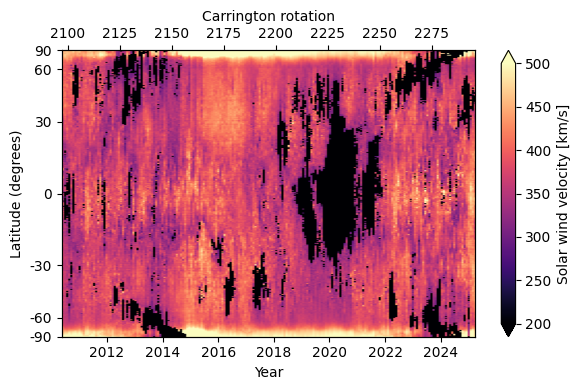

In [9]:
wfmap_exp[~np.isfinite(wfmap_exp)] = 0

f, (ax1) = plt.subplots(1, figsize=(6,4))
im = ax1.imshow(wfmap_exp, vmin=200, vmax=500, extent=[tmin, tmax, -1, 1], cmap='magma', aspect='auto')
plt.colorbar(im, ax=ax1, extend='both', label='Solar wind velocity [km/s]')

ax1b = ax1.twiny()
latticks = np.array([-90,-60,-30,0,30,60,90])
ax1.set_yticks(np.sin(latticks*np.pi/180))
ax1.set_yticklabels(latticks)
ax1b.set_xlim(crs[0], crs[-1])
ax1.xaxis_date()

ax1.set_xlabel('Year')
ax1b.set_xlabel('Carrington rotation')
ax1.set_ylabel('Latitude (degrees)')

plt.tight_layout()

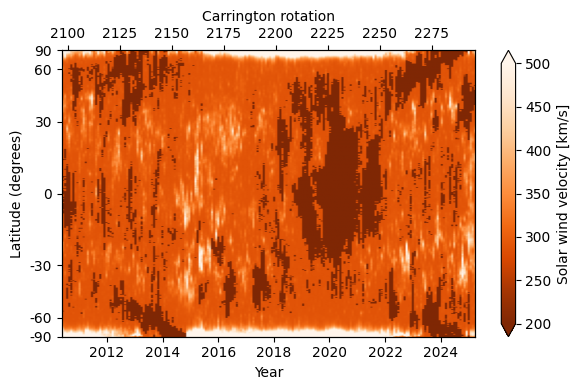

In [25]:
wfmap_wsa[~np.isfinite(wfmap_wsa)] = 0

f, (ax1) = plt.subplots(1, figsize=(6,4))
im = ax1.imshow(wfmap_wsa, vmin=200, vmax=500, extent=[tmin, tmax, -1, 1], cmap='Oranges_r', aspect='auto')
plt.colorbar(im, ax=ax1, extend='both', label='Solar wind velocity [km/s]')

ax1b = ax1.twiny()
latticks = np.array([-90,-60,-30,0,30,60,90])
ax1.set_yticks(np.sin(latticks*np.pi/180))
ax1.set_yticklabels(latticks)
ax1b.set_xlim(crs[0], crs[-1])
ax1.xaxis_date()

ax1.set_xlabel('Year')
ax1b.set_xlabel('Carrington rotation')
ax1.set_ylabel('Latitude (degrees)')

plt.tight_layout()
plt.savefig('pfss_wmap.pdf')

In [108]:
dmap[np.where(dmap == 0)] = np.nan

In [109]:
dmap = dmap * u.rad
dmap = dmap.to(u.deg)

In [110]:
wmap_wsa = 285 + (625 / (1+expfs)**(2/9)) * (1 - 0.8 * np.exp(-(dmap.value/2)**2))**3

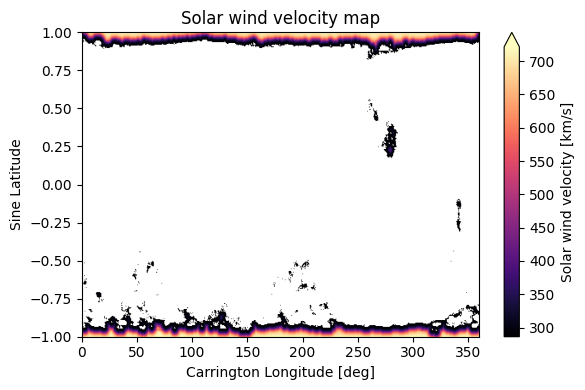

In [111]:
f, (ax1) = plt.subplots(1, figsize=(6,4))
im = ax1.imshow(wmap_wsa, cmap='magma', extent=[0,360, -1, 1], aspect='auto')
plt.colorbar(im, ax=ax1, extend='max', label='Solar wind velocity [km/s]')
ax1.set_xlabel('Carrington Longitude [deg]')
ax1.set_ylabel('Sine Latitude')
ax1.set_title('Solar wind velocity map')

plt.tight_layout()

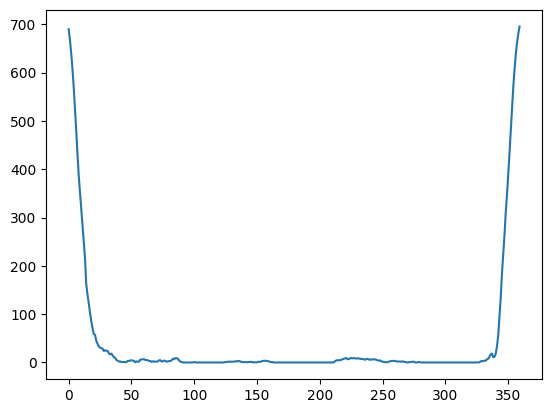

In [122]:
plt.plot(np.nansum(wmap_wsa, axis=1) / 720.)